<a href="https://colab.research.google.com/github/DietzscheNostoevsky/Learning_Pytorch/blob/main/02_Pytorch_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral Dataset

Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).

- Build a loss function and optimizer capable of handling multi-class data (optional extension: use the `Adam optimizer` instead of `SGD`, you may have to experiment with different values of the learning rate to get it working).

- Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).

- Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

## Creating Dataset

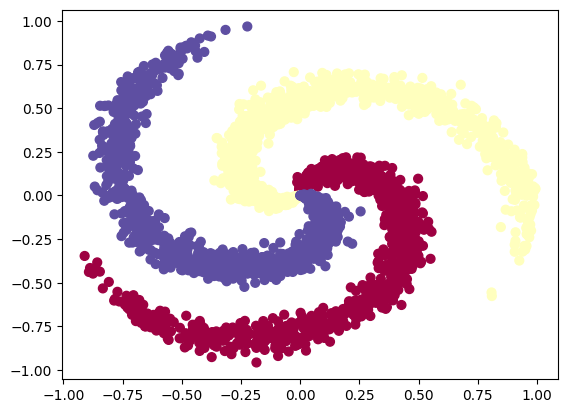

In [1]:
import numpy as np
import matplotlib.pyplot as plt
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

## Test-Train Split

In [20]:
#X_spiral, y_spiral = X, y

# Turning data into tensors 
import torch 

X_spiral = torch.from_numpy(X).type(torch.float)
y_spiral = torch.from_numpy(y).type(torch.long)

print(X_spiral.shape); print(type(X_spiral))
print(y_spiral.shape); print(type(y_spiral))

torch.Size([3000, 2])
<class 'torch.Tensor'>
torch.Size([3000])
<class 'torch.Tensor'>


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_spiral, y_spiral,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
print(X_train.shape); print(type(X_train))
print(X_test.shape); print(type(X_test))

print(y_train.shape); print(type(y_train))
print(y_test.shape); print(type(y_test))



torch.Size([2400, 2])
<class 'torch.Tensor'>
torch.Size([600, 2])
<class 'torch.Tensor'>
torch.Size([2400])
<class 'torch.Tensor'>
torch.Size([600])
<class 'torch.Tensor'>


In [23]:
for i in range(3):
    print(F"X_train: {X_train[i]}, y_train: {y_train[i]}")


X_train: tensor([ 0.4043, -0.4995]), y_train: 0
X_train: tensor([ 0.3529, -0.6054]), y_train: 0
X_train: tensor([0.1908, 0.1216]), y_train: 0


## Plotting train-test data

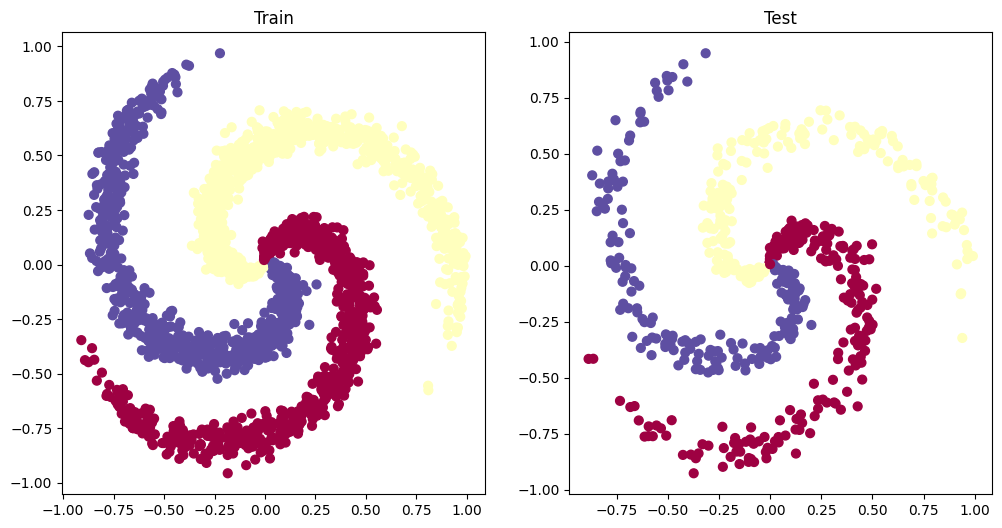

In [24]:
# Training Data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:], s=40, cmap=plt.cm.Spectral)
plt.subplot(1,2,2)
plt.title("Test")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test[:], s=40, cmap=plt.cm.Spectral)
plt.show()

## Data insights 

In [25]:
print(y_train.unique(return_counts=True))
print(y_test.unique(return_counts=True))


(tensor([0, 1, 2]), tensor([783, 803, 814]))
(tensor([0, 1, 2]), tensor([217, 197, 186]))


# Model ( Multiclass PyTorch Model )

In [26]:
import torch
from torch import nn

# Setting hyperparameters 

NUM_CLASSES = 3
NUM_FEATURES = 2
RANDOM_SEED = 42

# Building Model 

class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):

        
        super().__init__()
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# creating a model instance and sending it to device 

model_0 = SpiralModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8,)
print(model_0)


SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)


# Loss Function , Metrics and Optimizer 

In [27]:
# Metrics 

try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy


accuracy = Accuracy("multiclass", num_classes=NUM_CLASSES)
print(accuracy)

MulticlassAccuracy()


In [28]:
# Loss Function 
loss_fn = nn.CrossEntropyLoss() # This criterion computes the cross entropy loss between input logits and target.

# Optimizer 
optimizer_1 = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)
print(loss_fn)
print(optimizer_1) 


CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)


# Getting prediction Probabilities from Model

In [29]:
X_train[0,0].dtype

torch.float32

In [30]:
y_train.dtype

torch.int64

In [31]:
# Trying single pass 

model_0(X_train)

tensor([[-0.0787, -0.3452, -0.2389],
        [-0.0612, -0.3455, -0.2148],
        [-0.0961, -0.3871, -0.2818],
        ...,
        [-0.0606, -0.3630, -0.2293],
        [-0.0675, -0.3681, -0.2427],
        [-0.0265, -0.2917, -0.1497]], grad_fn=<AddmmBackward0>)

Output is presently in form of logits 

We go from `logits -> prediction probabilities -> prediction labels` 

That's where the `softmax activation function` comes into play.

In [32]:
# Making predictions logits with model 

y_logits = model_0(X_train)

# Performong softmax calculation on logits across dimension 1 to get predicton 

y_pred_probs = torch.softmax(y_logits, dim=1)   # SoftMax is vectorized, 
                                                # meaning that takes a vector with the 
                                                # same number of entries as classes 
                                                # we have and outputs another vector where 
                                                # each component represents the probability
                                                # of belonging to that class.
print(y_logits[:5])
print(y_pred_probs[:5])
#print(torch.round(y_pred_probs[:5],decimals=3))

tensor([[-0.0787, -0.3452, -0.2389],
        [-0.0612, -0.3455, -0.2148],
        [-0.0961, -0.3871, -0.2818],
        [-0.1377, -0.4123, -0.3541],
        [-0.0705, -0.3791, -0.2431]], grad_fn=<SliceBackward0>)
tensor([[0.3820, 0.2926, 0.3254],
        [0.3831, 0.2883, 0.3286],
        [0.3879, 0.2900, 0.3221],
        [0.3898, 0.2962, 0.3140],
        [0.3882, 0.2851, 0.3267]], grad_fn=<SliceBackward0>)


In [33]:
# check sum across the row 
torch.sum(y_pred_probs[:5], dim=1, keepdim=True)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SumBackward1>)

Since there's one value for each class in y_pred_probs, the `index` of the highest value is the class the model thinks the specific data sample most belongs to

In [34]:
# Checking class using argmax
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3820, 0.2926, 0.3254], grad_fn=<SelectBackward0>)
tensor(0)


In multiclass classification, you have two common approaches for obtaining predictions:

1. Using Argmax: You can directly apply the `torch.argmax` function on the logits to obtain the predicted class labels. The `torch.argmax` function returns the index of the maximum value along a specified axis. In the case of multiclass classification, you typically apply it along the class dimension. For example:

   ```python
   logits = model(x)  # Forward pass to get logits
   predicted_labels = torch.argmax(logits, dim=1)
   ```

   This approach gives you the predicted class labels directly from the logits without converting them to probabilities. It assumes that the class with the highest logit value is the predicted class.

2. Converting Logits to Probabilities: Alternatively, you can apply a softmax function on the logits to obtain the prediction probabilities for each class. The softmax function normalizes the logits and converts them into probabilities that sum to 1. You can use `torch.softmax` for this:

   ```python
   logits = model(x)  # Forward pass to get logits
   predicted_probs = torch.softmax(logits, dim=1)
   ```

   After obtaining the probabilities, you can use them for further analysis or choose the class with the highest probability as the predicted class label.

Both approaches are valid for multiclass classification. If you are only interested in the predicted class labels, using `torch.argmax` on the logits is a simpler and more direct approach. However, if you need the probabilities for other purposes (e.g., evaluating confidence or uncertainty), converting logits to probabilities using softmax can be beneficial.

# Training and Testing loop 

In [40]:
# Random Seed 

torch.manual_seed(RANDOM_SEED)

from tqdm.auto import trange, tqdm 
epochs = 10000

# Training Loop 

for epoch in trange(epochs):
    model_0.train()

    # 1. Forward Pass 
    y_logits = model_0(X_train) # to calculate loss 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calcilating loss and Accuracy 

    loss = loss_fn(y_logits, y_train) # need logits 
                   
    
    acc = accuracy(preds=y_pred,
                   target=y_train)

    # 3. Optimizer zero grad 

    optimizer_1.zero_grad() # using SGD

    # 4. Loss Backward
    loss.backward()
    
    #5. Optimizer Step 

    optimizer_1.step()

    # Testing 

    model_0.eval()
    with torch.inference_mode():
        #1 Forward Pass
        test_logits = model_0(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. test loss and accuracy 

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(preds=test_pred,
                   target=y_test)
    # Printouts 

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 
    
    

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.36103, Acc: 0.84% | Test Loss: 0.37223, Test Acc: 0.83%
Epoch: 1000 | Loss: 0.21382, Acc: 0.93% | Test Loss: 0.21849, Test Acc: 0.91%
Epoch: 2000 | Loss: 0.12173, Acc: 0.96% | Test Loss: 0.12487, Test Acc: 0.95%
Epoch: 3000 | Loss: 0.08867, Acc: 0.97% | Test Loss: 0.08336, Test Acc: 0.97%
Epoch: 4000 | Loss: 0.07426, Acc: 0.98% | Test Loss: 0.06542, Test Acc: 0.98%
Epoch: 5000 | Loss: 0.05773, Acc: 0.98% | Test Loss: 0.04681, Test Acc: 0.98%
Epoch: 6000 | Loss: 0.04055, Acc: 0.98% | Test Loss: 0.03208, Test Acc: 0.99%
Epoch: 7000 | Loss: 0.03161, Acc: 0.99% | Test Loss: 0.02459, Test Acc: 0.99%
Epoch: 8000 | Loss: 0.02587, Acc: 0.99% | Test Loss: 0.02022, Test Acc: 0.99%
Epoch: 9000 | Loss: 0.02140, Acc: 1.00% | Test Loss: 0.01709, Test Acc: 0.99%


# Plotting results

In [36]:
# Importing from previous modules 

import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

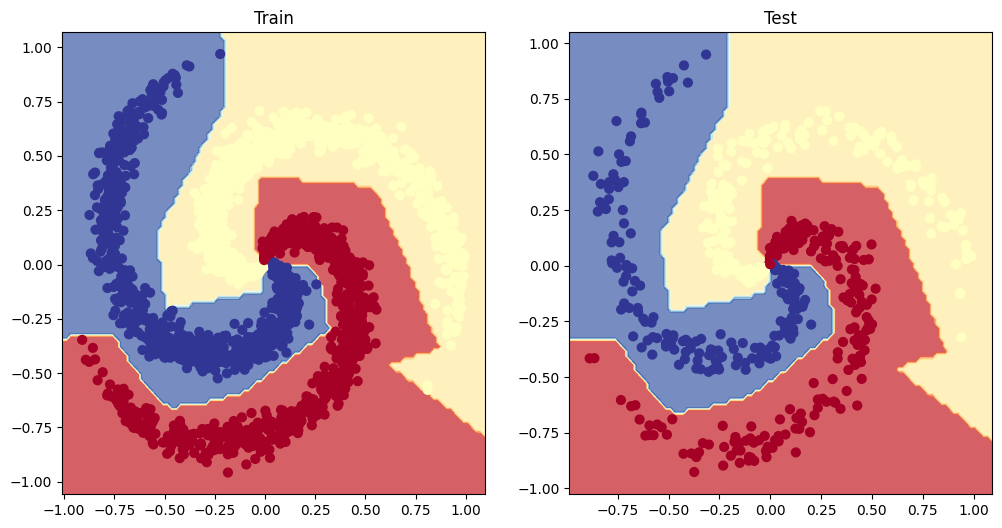

In [41]:
from helper_functions import *
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Model_0 with Adam optimizer 

In [43]:
model_1 = SpiralModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8,)
print(model_1)
optimizer_2 = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.1)
print(optimizer_2)

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.01747, Acc: 1.00% | Test Loss: 0.01374, Test Acc: 1.00%
Epoch: 10 | Loss: 0.01559, Acc: 1.00% | Test Loss: 0.01261, Test Acc: 1.00%
Epoch: 20 | Loss: 0.01419, Acc: 1.00% | Test Loss: 0.01177, Test Acc: 1.00%
Epoch: 30 | Loss: 0.01303, Acc: 1.00% | Test Loss: 0.01112, Test Acc: 1.00%
Epoch: 40 | Loss: 0.01208, Acc: 1.00% | Test Loss: 0.01056, Test Acc: 1.00%
Epoch: 50 | Loss: 0.01126, Acc: 1.00% | Test Loss: 0.01005, Test Acc: 1.00%
Epoch: 60 | Loss: 0.01058, Acc: 1.00% | Test Loss: 0.00964, Test Acc: 1.00%
Epoch: 70 | Loss: 0.00999, Acc: 1.00% | Test Loss: 0.00930, Test Acc: 1.00%
Epoch: 80 | Loss: 0.00947, Acc: 1.00% | Test Loss: 0.00903, Test Acc: 1.00%
Epoch: 90 | Loss: 0.00901, Acc: 1.00% | Test Loss: 0.00879, Test Acc: 1.00%


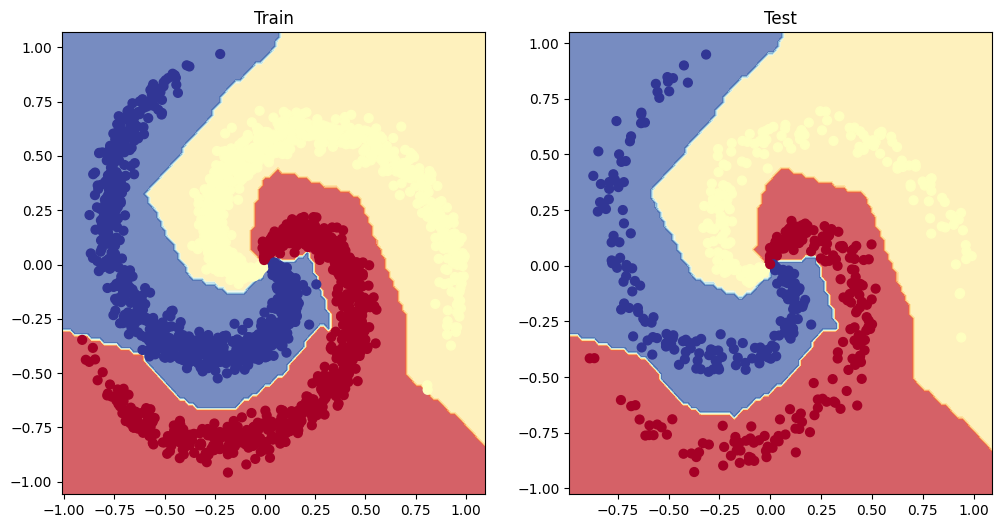

In [45]:
# Random Seed 

torch.manual_seed(RANDOM_SEED)

from tqdm.auto import trange, tqdm 
epochs = 100

# Training Loop 

for epoch in trange(epochs):
    model_1.train()

    # 1. Forward Pass 
    y_logits = model_1(X_train) # to calculate loss 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calcilating loss and Accuracy 

    loss = loss_fn(y_logits, y_train) # need logits 
                   
    
    acc = accuracy(preds=y_pred,
                   target=y_train)

    # 3. Optimizer zero grad 

    optimizer_2.zero_grad() # using Adam

    # 4. Loss Backward
    loss.backward()
    
    #5. Optimizer Step 

    optimizer_2.step()

    # Testing 

    model_1.eval()
    with torch.inference_mode():
        #1 Forward Pass
        test_logits = model_1(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. test loss and accuracy 

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(preds=test_pred,
                   target=y_test)
    # Printouts 

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

from helper_functions import *
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
    

# Conclusion : 

SGD took > 10000 epochs to reach the same accuracy as Adam in 100 epochs 